# 0. Settings

In [19]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torchvision
import os
import zipfile

from torchvision import datasets
from torchvision import transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [6]:
np.__version__

'1.20.3'

In [10]:
matplotlib.__version__

'3.4.3'

In [3]:
%matplotlib inline

---

# 1. Data Load




## 1-0. Data Download

![](https://velog.velcdn.com/images/olxtar/post/116994e9-a354-4936-ad5d-ea3ae20e42e2/image.png)

랜드마크 데이터 다운로드 링크 : https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip

<br/>

* 50개의 랜드마크 클래스
* 이미지 사이즈 Un-uniform

## 1-1. Data Extract

로컬PC Landmark_Classification 폴더에 Landmark dataset 압축파일을 (다운로드 후) 직접 넣어주고 아래와 같이 알집해제하자

In [2]:
# 현재 경로 체크
os.getcwd()

'C:\\Users\\USER\\Desktop\\Landmark_Classification'

In [6]:
# 해당 python jupyter notebook working directory인 경로에 압축해제

zipfile_path = 'C:\\Users\\USER\\Desktop\\Landmark_Classification/landmark_images.zip'

landmark_image_zip = zipfile.ZipFile(zipfile_path)
landmark_image_zip.extractall()

landmark_image_zip.close()

In [10]:
# 현재 경로 파일 체크 (압축해제확인)
# landmark_images 폴더 생성 체크
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'landmark_images',
 'landmark_images.zip',
 'Project2_github.ipynb',
 'Project2_Landmark_Classification.ipynb']

## 1-2. Data path check 

In [17]:
repository_path = os.getcwd()
traindata_path = os.path.join(repository_path, 'landmark_images', 'train')
testdata_path = os.path.join(repository_path, 'landmark_images', 'test')

In [50]:
# train folder 내 클래스 폴더명들과 test foler 내 클래스 폴더명들이 일치하는지
os.listdir(traindata_path) == os.listdir(testdata_path)

True

---

# 2. Create a CNN (from scratch)

## 2-1. DataLoader

<span style="color:green">**[+]**</span> dataset, DataLoader 만들기 프로세스

1. `batch_size`, `num_workers`, `val_size`, `data_path`(데이터경로), `transforms`등을 설정
2. Datasets 만들기 $\rightarrow$ `torchvision.datasets.ImageFolder()`

3. Train set / Validation set 나누고 Sampler 만들기 $\rightarrow$ 인덱스 나누고, 셔플 등
4. DataLoader 만들기

### 2-1-1. Variable Setting for DataLoader

In [3]:
batch_size = 20
num_workers = 0
val_size = 0.2

data_folder_path = os.path.join(os.getcwd(), 'landmark_images')
train_folder_path = os.path.join(data_folder_path, 'train')
test_folder_path = os.path.join(data_folder_path, 'test')

my_transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

### 2-1-2. Make datasets

In [4]:
train_data = datasets.ImageFolder(train_folder_path, transform = my_transform)
test_data = datasets.ImageFolder(test_folder_path, transform = my_transform)

In [14]:
# Check
print(type(train_data))
print(type(test_data))

print(len(train_data))
print(len(test_data))

# print(train_data.classes)        
# print(test_data.classes)

# print(train_data.class_to_idx)
# print(test_data.class_to_idx)

<class 'torchvision.datasets.folder.ImageFolder'>
<class 'torchvision.datasets.folder.ImageFolder'>
4996
1250


### 2-1-3. Train / Valid

In [5]:
num_train = len(train_data)       # 4996
indices = list(range(num_train))  # 0~4995까지의 값이 순차적으로 있는 list
np.random.shuffle(indices)        # 0~4995까지의 값이 랜덤하게 있는 list로 셔플

split = int(np.floor(val_size * num_train))   # 4996 * 0.2 내림+정수 -> 999
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

<span style="color:green">**[+]**</span> `SubsetRandomSampler` : parameter로 주어진 리스트 내의 값(인덱스)로만 1개씩 iterator로 랜덤추출

### 2-1-4. Make DataLoader

In [6]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           sampler = train_sampler,
                                           num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           sampler = valid_sampler,
                                           num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = batch_size,
                                          num_workers = num_workers)

<span style="color:orange">**[!]**</span> DataLoader는 리스트를 뱉음 $\downarrow$ 아래참고
1. 리스트 0번째 요소는 이미지 Tensor'들' (batch size x channels x height x width)
2. 리스트 1번째 요소는 해당 이미지의 Label값'들'

In [7]:
next(iter(train_loader))[0].shape

torch.Size([20, 3, 256, 256])

In [8]:
next(iter(train_loader))[1]

tensor([31,  1,  1,  4, 25, 38, 26,  5,  9, 30,  6, 16, 39, 19, 25, 43, 20, 30,
        29, 35])

<span style="color:green">**[+]**</span> DataLoader Dictionary 생성 $\downarrow$

In [9]:
loaders_scratch = {'train' : train_loader,
                   'valid' : valid_loader,
                   'test' : test_loader}

<span style="color:green">**[+]**</span> 이미지 데이터의 Class 체크 $\downarrow$

In [10]:
class_li = [classes_name.split(".")[1] for classes_name in train_data.classes]

In [11]:
class_li

['Haleakala_National_Park',
 'Mount_Rainier_National_Park',
 'Ljubljana_Castle',
 'Dead_Sea',
 'Wroclaws_Dwarves',
 'London_Olympic_Stadium',
 'Niagara_Falls',
 'Stonehenge',
 'Grand_Canyon',
 'Golden_Gate_Bridge',
 'Edinburgh_Castle',
 'Mount_Rushmore_National_Memorial',
 'Kantanagar_Temple',
 'Yellowstone_National_Park',
 'Terminal_Tower',
 'Central_Park',
 'Eiffel_Tower',
 'Changdeokgung',
 'Delicate_Arch',
 'Vienna_City_Hall',
 'Matterhorn',
 'Taj_Mahal',
 'Moscow_Raceway',
 'Externsteine',
 'Soreq_Cave',
 'Banff_National_Park',
 'Pont_du_Gard',
 'Seattle_Japanese_Garden',
 'Sydney_Harbour_Bridge',
 'Petronas_Towers',
 'Brooklyn_Bridge',
 'Washington_Monument',
 'Hanging_Temple',
 'Sydney_Opera_House',
 'Great_Barrier_Reef',
 'Monumento_a_la_Revolucion',
 'Badlands_National_Park',
 'Atomium',
 'Forth_Bridge',
 'Gateway_of_India',
 'Stockholm_City_Hall',
 'Machu_Picchu',
 'Death_Valley_National_Park',
 'Gullfoss_Falls',
 'Trevi_Fountain',
 'Temple_of_Heaven',
 'Great_Wall_of_China',

## 2-2. Visualize a Batch of Training Data 

<span style="color:green">**[+]**</span> `torchvision.datasets.ImageFolder` 객체는 iterator로 사용 시 1개의 이미지 Tensor와 해당 이미지의 Label값을 Tuple로 뱉는다

In [9]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [10]:
next(iter(train_data))

(tensor([[[-0.7647, -0.7412, -0.7020,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5608, -0.5765, -0.5608,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5294, -0.4745, -0.4745,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [-0.9059, -0.9059, -0.9137,  ..., -0.2784, -0.2784, -0.2863],
          [-0.8980, -0.9059, -0.8980,  ..., -0.2863, -0.2706, -0.2392],
          [-0.9137, -0.9294, -0.9294,  ..., -0.2784, -0.2314, -0.1529]],
 
         [[-0.7412, -0.7255, -0.7020,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5451, -0.5608, -0.5686,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5137, -0.4588, -0.4824,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [-0.9059, -0.9216, -0.9137,  ..., -0.3412, -0.3255, -0.3333],
          [-0.8667, -0.8980, -0.8980,  ..., -0.3333, -0.3176, -0.2941],
          [-0.8431, -0.8980, -0.8980,  ..., -0.3098, -0.2784, -0.2157]],
 
         [[-0.7490, -0.7333, -0.6941,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5529, -0.5686,

In [20]:
t_img_tensor = train_data[4321][0]
t_img_label = train_data[4321][1]
# 첫번째 인덱스 : train data에서 n번째 이미지와 라벨
# 두번째 인덱스 : n번째 이미지(1개)에서 이미지 Tensor만
print(f"이미지 Tensor shape : {t_img_tensor.shape}")
print(f"이미지 label : {t_img_label}")

이미지 Tensor shape : torch.Size([3, 256, 256])
이미지 label : 43


<span style="color:green">**[+]**</span> `torchvision.transforms`를 통하여 normalize 및 tensor로 변환된 이미지 텐서를 다시 NumPy Array로 바꿔주기

`transforms.Compose([ ])`의 역순, 즉 tensor로 변환 후 normalize해줬으므로

여기서는 Un-normalize해주고 Tensor $\rightarrow$ Numpy Array

In [21]:
# Un-normalize (normalize시 0.5로 나눠주고 0.5를 뺏으므로 역으로)
t_img_tensor_unnormalized = t_img_tensor * 0.5 + 0.5    

In [22]:
t_img_tensor_unnormalized_nparray = np.transpose(np.asarray(t_img_tensor_unnormalized),
                                                 (1,2,0))

In [23]:
t_img_nparray = (t_img_tensor_unnormalized_nparray * 255).astype(np.uint8)

In [24]:
img = Image.fromarray(t_img_nparray)

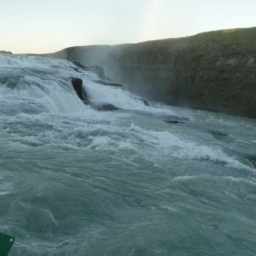

In [25]:
img

### 2-2-1. Un-Transform Function (for Visualization)

In [12]:
def Untransform(image_tensor):
    image_tensor_unnormalized = (image_tensor * 0.5) + 0.5
    image_array_unnormalized = np.transpose(np.asarray(image_tensor_unnormalized),
                                           (1,2,0))
#     plt.imshow(image_array_unnormalized)
    image_array = (image_array_unnormalized * 255).astype(np.uint8)
    
    return image_array

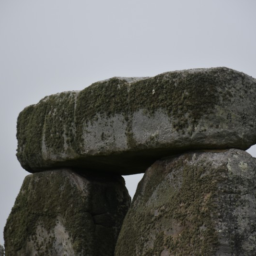

In [13]:
# PIL.Image로 시각화 해보기
Image.fromarray(Untransform(train_data[741][0]))

<span style="color:orange">**[!]**</span> `matplotlib.pyplot.imshow()`에서 계속 에러나와서 시각화 포기

## 2-3. CUDA

In [14]:
train_on_gpu = torch.cuda.is_available()

In [16]:
if not train_on_gpu:
    print("CUDA is not available. Training on CPU ...")
else:
    print("CUDA is available! Training on GPU ...")

CUDA is not available. Training on CPU ...


## 2-4. Specify Loss Function and Optimizer

In [18]:
# import torch.optim as optim
# import torch.nn as nn

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    return optim.SGD(model.parameters(), lr=0.01)

## 2-5. Model Architecture
<span style="color:green">**[+]**</span> **Max Pooling layer** :`MaxPool2d(kerne_size=2, stride=2)` 를 지나가면 이미지의 Height, Width가 절반씩 줄어든다

* *Size : (depth x height x width)
* input size : (3 x 256 x 256)
* conv1+pool output size : (16 x 128 x 128)
* conv2+pool output size : (32 x 64 x 64) 
* conv3|+pool output size : (64 x 32 x 32)

<span style="color:orange">**[!]**</span> 따라서 첫번째 Fully-Connected Layer에 들어가는 input node 개수는 (64 x 32 x 32) 

In [25]:
# import torch.nn as nn
# import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64*32*32, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 50)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64*32*32)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    
model_scratch = Net()

if train_on_gpu:
    model_scratch.cuda()